In [1]:
import os
from functools import reduce
from typing import List
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from Model.ModelEarly2D import ModelEarly2D, ModeTestChannel
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

read config params

In [2]:
f = open("config.txt")
configParams = f.readlines()
f.close()
configParams = eval("\n".join(configParams))

multiplierCoord = configParams["multiplierCoord"]
thresholdCuDi = configParams["thresholdCuDi"]# value in pixel
dimensionsImage,canal = np.array(configParams["dimensionsOutputImage"]),2 # x and
actionFileName = "Actions.csv"

In [3]:
nbClass=21
pathModelGeneral,separator = "C:\\workspace2\\Datasets\\2D\\ILGDB\\Log\\leafy-donkey\\","\\"
pathModel = pathModelGeneral+"model"
pathPreprocessedDataTest = "C:\\workspace2\\Datasets\\2D\\ILGDB\\PreprocessedUntrimmedX5_withValid\\Test\\"


### Prepare the test data

In [4]:
# testFiles = os.listdir(pathPreprocessedData+"Test")
# nbTest = len(testFiles)


datasetTest = tf.data.experimental.load(pathPreprocessedDataTest)


datasetTest = datasetTest.batch(1)


In [5]:
model = tf.keras.models.load_model(pathModel,compile=False)
opti = tf.keras.optimizers.Adam()
model.compile(opti, loss=[], metrics=[])

In [6]:
iterator = iter(datasetTest)

In [7]:
elem1 = next(iterator)
#

In [8]:
eval = model(elem1[0])
print(eval[0].shape)

(1, 115, 22)


In [9]:
# print(elem1[0].shape)
# print(elem1[2].shape)
# print(elem1[3].shape)

In [10]:
iterator = iter(datasetTest)



N = [0]*nbClass
TrueAccept = [0]*nbClass
FalseAccept = [0]*nbClass
TrueAcceptAt = []
FalseAcceptAt = []

TrueAcceptWoReject = [0]*nbClass
FalseAcceptWoReject = [0]*nbClass
averageLengthCompletion = [[] for i in range(nbClass)]

rejected = [0]*nbClass
# FalseReject = 0
# TrueReject = 0
# ScoreByLength = {}


t = 1 #number of time the accepted prediction must be repeated to be accepted
confMatrix = np.zeros([nbClass, nbClass], dtype=int)

for i,data in enumerate(iterator):
    #data : ( input             : (1, 217, 40, 40, 2)
    #        perFrameGT         : (1, 217, 1),
    #        perFrameGT (same)  : (1, 217, 1),
    #        classId_start_end  : (1, 10, 3),
    # )
    nbGesture = tf.shape(data[3])[1]
    input = data[0]
    prediction = model(input,training=False)[0][0] # get prediction output
    for gestureIndex in range(nbGesture):
        GT, start, end = data[3][0][gestureIndex]
        predictionLocal = prediction[start:end+1,:]

    # if(i%100==0):
    #     print(i,"/",len(testFiles))
    # file = testFiles[i]
    # print(file)
        # GT = data[1][0][0][0][0].numpy() # the GT is repeted along this axis
        # if(GT>1):
        #     GT-=1
        # elif(GT==1):
        #     GT=31
        # orginalLengthWithoutBlack = input.shape[1]-1
        # nbBlackImgToAdd = 8
        # blacks = tf.zeros([1,nbBlackImgToAdd,40,40,2])
        # input = tf.concat([input,blacks],axis=1)
        orginalLength = end-start+1 # -2 because some gestures have some intermediate black frames

        N[int(GT)]+=1
        treshAccept = 0.5
        # print("prediction",tf.shape(prediction))
        rejection = predictionLocal[:,0]
        rejection = tf.greater(rejection,treshAccept).numpy()
        predictionLocal = predictionLocal[:,1:]
        predictionLocal = tf.argmax(predictionLocal,axis=1).numpy()
        acceptIndex = np.where(rejection>treshAccept)[0]
        if len(acceptIndex)>0 :# or predictionLocal[-1]==0 or predictionLocal[-1]==5:
            # if len(acceptIndex)==0  and ( predictionLocal[-1]==0 or predictionLocal[-1]==5):
            #     acceptIndex = [len(predictionLocal)-1]

          # get results if we don't use the rejet, use the result of the last frame
            if predictionLocal[-1]==GT:
                TrueAcceptWoReject[int(GT)]+=1
            else:
                FalseAcceptWoReject[int(GT)]+=1

            firstAcceptIndex = acceptIndex[0]
            repeatedTTime = False
            if t>1: # if we want to repeat the prediction t times to assure this is the good class
                currentClass = predictionLocal[firstAcceptIndex]
                cpt_repeat=0 # 0 because first loop is the currentClass
                while firstAcceptIndex<len(predictionLocal) and not repeatedTTime:
                    predi = predictionLocal[firstAcceptIndex]
                    if currentClass == predi:
                        cpt_repeat+=1
                        if cpt_repeat>=t:
                            repeatedTTime=True
                            break
                    else:
                        currentClass = predi
                        cpt_repeat = 1
                    firstAcceptIndex+=1
                if not repeatedTTime: # if the prediction is never repeated t times, it is rejected
                    rejected[int(GT)] +=1
                    continue # don't do the rest
            pred = predictionLocal[firstAcceptIndex]

            itemFirstAccept = firstAcceptIndex+1 #we have seen this frame, so count it in earliness
            if firstAcceptIndex>orginalLength:
                itemFirstAccept = orginalLength # possible if less than 2 black frame
            if pred==GT:
                TrueAccept[int(GT)]+=1
                TrueAcceptAt+=[float(itemFirstAccept)/(float(orginalLength))]
                averageLengthCompletion[int(GT)]+=[float(itemFirstAccept)/(float(orginalLength))]
            else:
                FalseAccept[int(GT)]+=1
                FalseAcceptAt+=[float(itemFirstAccept)/(float(orginalLength))]
            confMatrix[int(GT)][pred]+=1
        else:
            rejected[int(GT)] +=1




In [11]:
N = np.array(N)
TrueAccept = np.array(TrueAccept)
FalseAccept = np.array(FalseAccept)
rejected = np.array(rejected)
avPerClass = [sum(av)/len(av) if len(av)>0 else 1 for av in averageLengthCompletion]

res = ""
res+="TrueAcceptPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in TrueAccept/N])))+"\n"
res+="FalseAcceptPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in  FalseAccept/N])))+"\n"
res+="rejectedPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in rejected/N])))+"\n"
res+="averageLengthCompletionPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in avPerClass])))+"\n"
N_ = sum(np.array(N))
TrueAccept_ = sum(np.array(TrueAccept))
FalseAccept_ = sum(np.array(FalseAccept))
rejected_ = sum(np.array(rejected))
res+="TrueAccept,\n"+str(TrueAccept_/N_)+"\n"
res+="FalseAccept,\n"+str(FalseAccept_/N_)+"\n"
res+="rejected,\n"+str(rejected_/N_)+"\n"
allAv = reduce(lambda a,b:a+b,averageLengthCompletion)
av = sum(allAv)/len(allAv)
res+="averageLengthCompletion\n"+str(av)+"\n"


print(res)



TrueAcceptPerClass,
0.44 ; 0.57 ; 0.76 ; 0.76 ; 0.44 ; 0.64 ; 0.71 ; 0.87 ; 0.66 ; 0.22 ; 0.74 ; 0.84 ; 0.72 ; 0.55 ; 0.72 ; 0.73 ; 0.81 ; 0.71 ; 0.55 ; 0.51 ; 0.61
FalseAcceptPerClass,
0.14 ; 0.08 ; 0.24 ; 0.10 ; 0.12 ; 0.31 ; 0.24 ; 0.08 ; 0.32 ; 0.40 ; 0.13 ; 0.10 ; 0.15 ; 0.40 ; 0.28 ; 0.18 ; 0.05 ; 0.24 ; 0.36 ; 0.41 ; 0.39
rejectedPerClass,
0.42 ; 0.35 ; 0.00 ; 0.15 ; 0.44 ; 0.05 ; 0.04 ; 0.05 ; 0.02 ; 0.38 ; 0.13 ; 0.06 ; 0.13 ; 0.05 ; 0.00 ; 0.09 ; 0.14 ; 0.05 ; 0.09 ; 0.08 ; 0.00
averageLengthCompletionPerClass,
1.03 ; 0.73 ; 0.66 ; 0.81 ; 0.96 ; 0.76 ; 0.86 ; 0.61 ; 0.76 ; 0.93 ; 0.79 ; 0.76 ; 0.94 ; 0.82 ; 0.74 ; 0.89 ; 0.79 ; 0.61 ; 0.84 ; 0.81 ; 0.72
TrueAccept,
0.619281045751634
FalseAccept,
0.2508169934640523
rejected,
0.12990196078431374
averageLengthCompletion
0.7846358576232669



In [12]:
f = open(pathModelGeneral+"resultsEvalCTC"+("_t"+str(t) if t>1 else "")+".txt","w+")
f.write(res)
f.close()

## scores wihtout reject option, take prediction of last frame

In [13]:
TrueAcceptWoReject  = np.array(TrueAcceptWoReject)
FalseAcceptWoReject = np.array(FalseAcceptWoReject)
res = ""
res+="GoodPredPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in TrueAcceptWoReject/N])))+"\n"
res+="FalsePredPerClass,\n"+str(" ; ".join(list(["{:.2f}".format(v) for v in  FalseAcceptWoReject/N])))+"\n"
TrueAcceptWoReject_ = sum(np.array(TrueAcceptWoReject))
FalseAcceptWoReject_ = sum(np.array(FalseAcceptWoReject))
Accuracy = (TrueAcceptWoReject_)/(TrueAcceptWoReject_+FalseAcceptWoReject_)
res+="Accuracy : "+str(Accuracy)+"\n"
res+="Error rate : "+str(1-Accuracy)

print(res)

GoodPredPerClass,
0.41 ; 0.51 ; 0.83 ; 0.56 ; 0.39 ; 0.65 ; 0.69 ; 0.76 ; 0.68 ; 0.26 ; 0.59 ; 0.76 ; 0.65 ; 0.49 ; 0.80 ; 0.45 ; 0.81 ; 0.71 ; 0.60 ; 0.64 ; 0.76
FalsePredPerClass,
0.17 ; 0.14 ; 0.17 ; 0.29 ; 0.17 ; 0.29 ; 0.27 ; 0.19 ; 0.29 ; 0.36 ; 0.28 ; 0.18 ; 0.22 ; 0.45 ; 0.20 ; 0.45 ; 0.05 ; 0.24 ; 0.31 ; 0.28 ; 0.24
Accuracy : 0.6995305164319249
Error rate : 0.3004694835680751


In [14]:
f = open(pathModelGeneral+"resultsEvalAccuracyWoReject.txt","w+")
f.write(res)
f.close()

## Exploring per class earliness

In [15]:
f = open(pathPreprocessedDataTest+actionFileName)
actions  =  f.readlines()
f.close()
actions = list(map(lambda s: s.split(";")[1].strip(),actions))

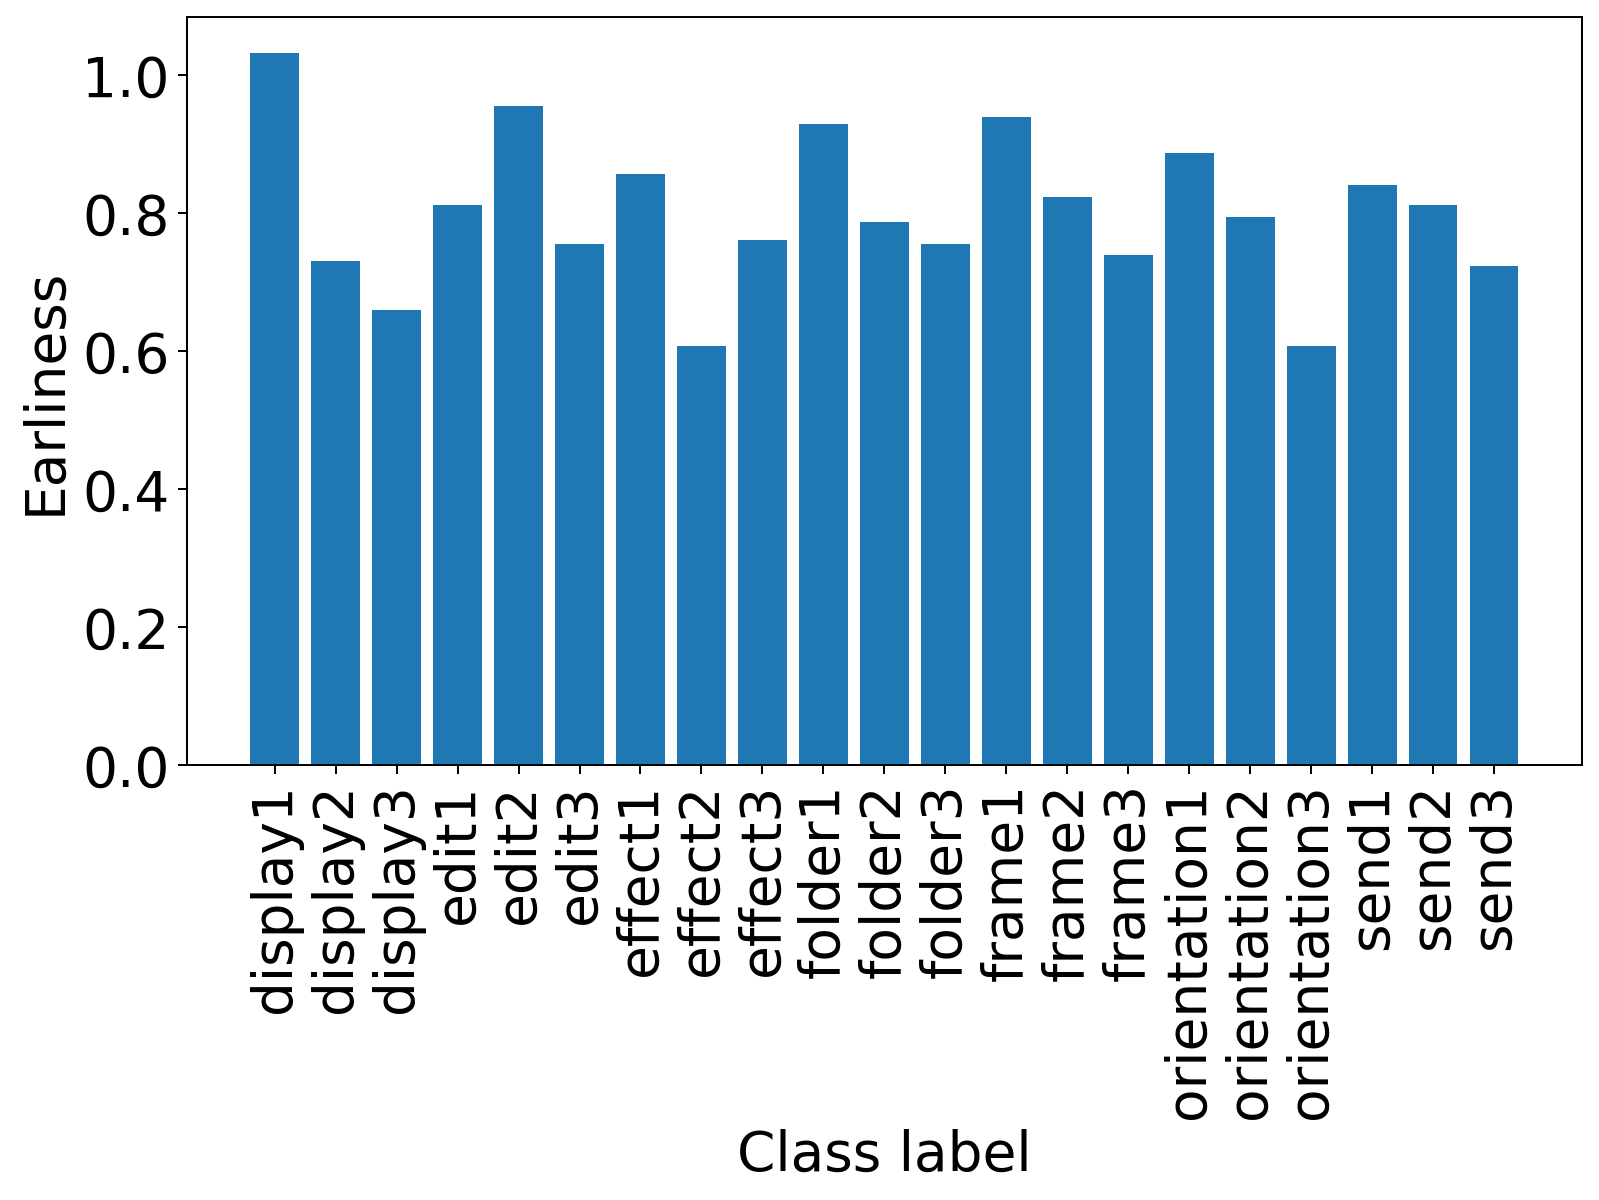

In [16]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,5.5),dpi=180)
plt.xticks(rotation=90)


_ = plt.bar(actions, avPerClass)


plt.xlabel('Class label')
plt.ylabel('Earliness')
# plt.title('Histogram representing the earliness of each class')

plt.savefig(pathModelGeneral+"earlinessPerClass"+("_t"+str(t) if t>1 else ""), bbox_inches='tight')
plt.savefig(pathModelGeneral+"earlinessPerClass"+("_t"+str(t) if t>1 else "")+".eps", bbox_inches='tight',format='eps')

## Confusion matrix

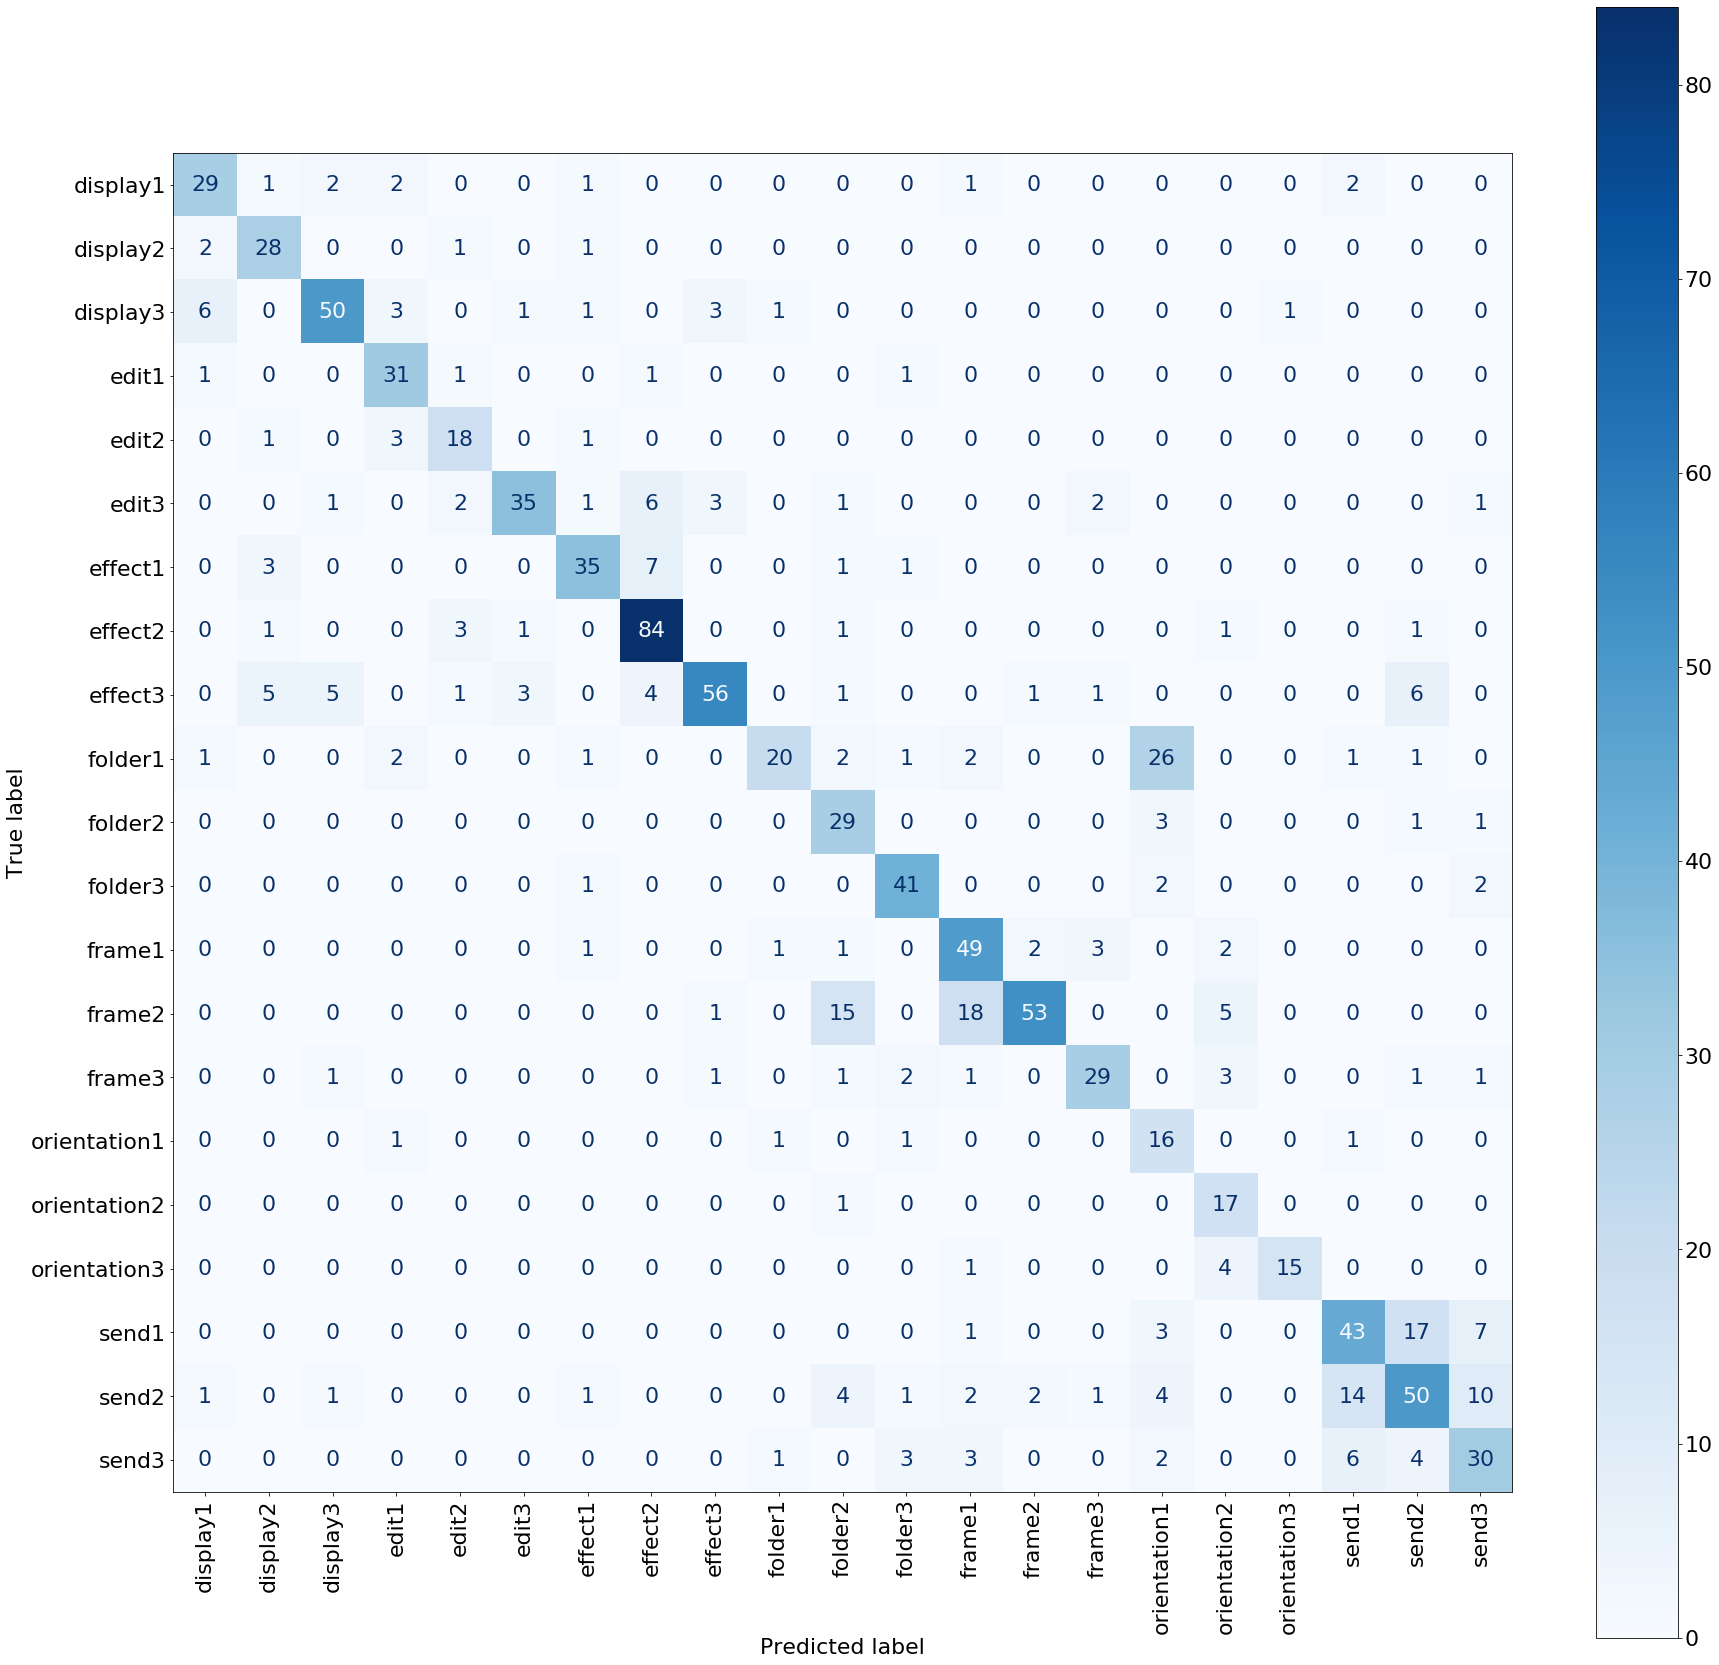

In [17]:
fig, ax = plt.subplots(figsize=(30, 30))
disp = ConfusionMatrixDisplay(confusion_matrix=confMatrix, display_labels=actions)
disp.plot(include_values=True, cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax, values_format="")
plt.savefig(pathModelGeneral + "confusionMatrix"+("_t"+str(t) if t>1 else "")+".png")

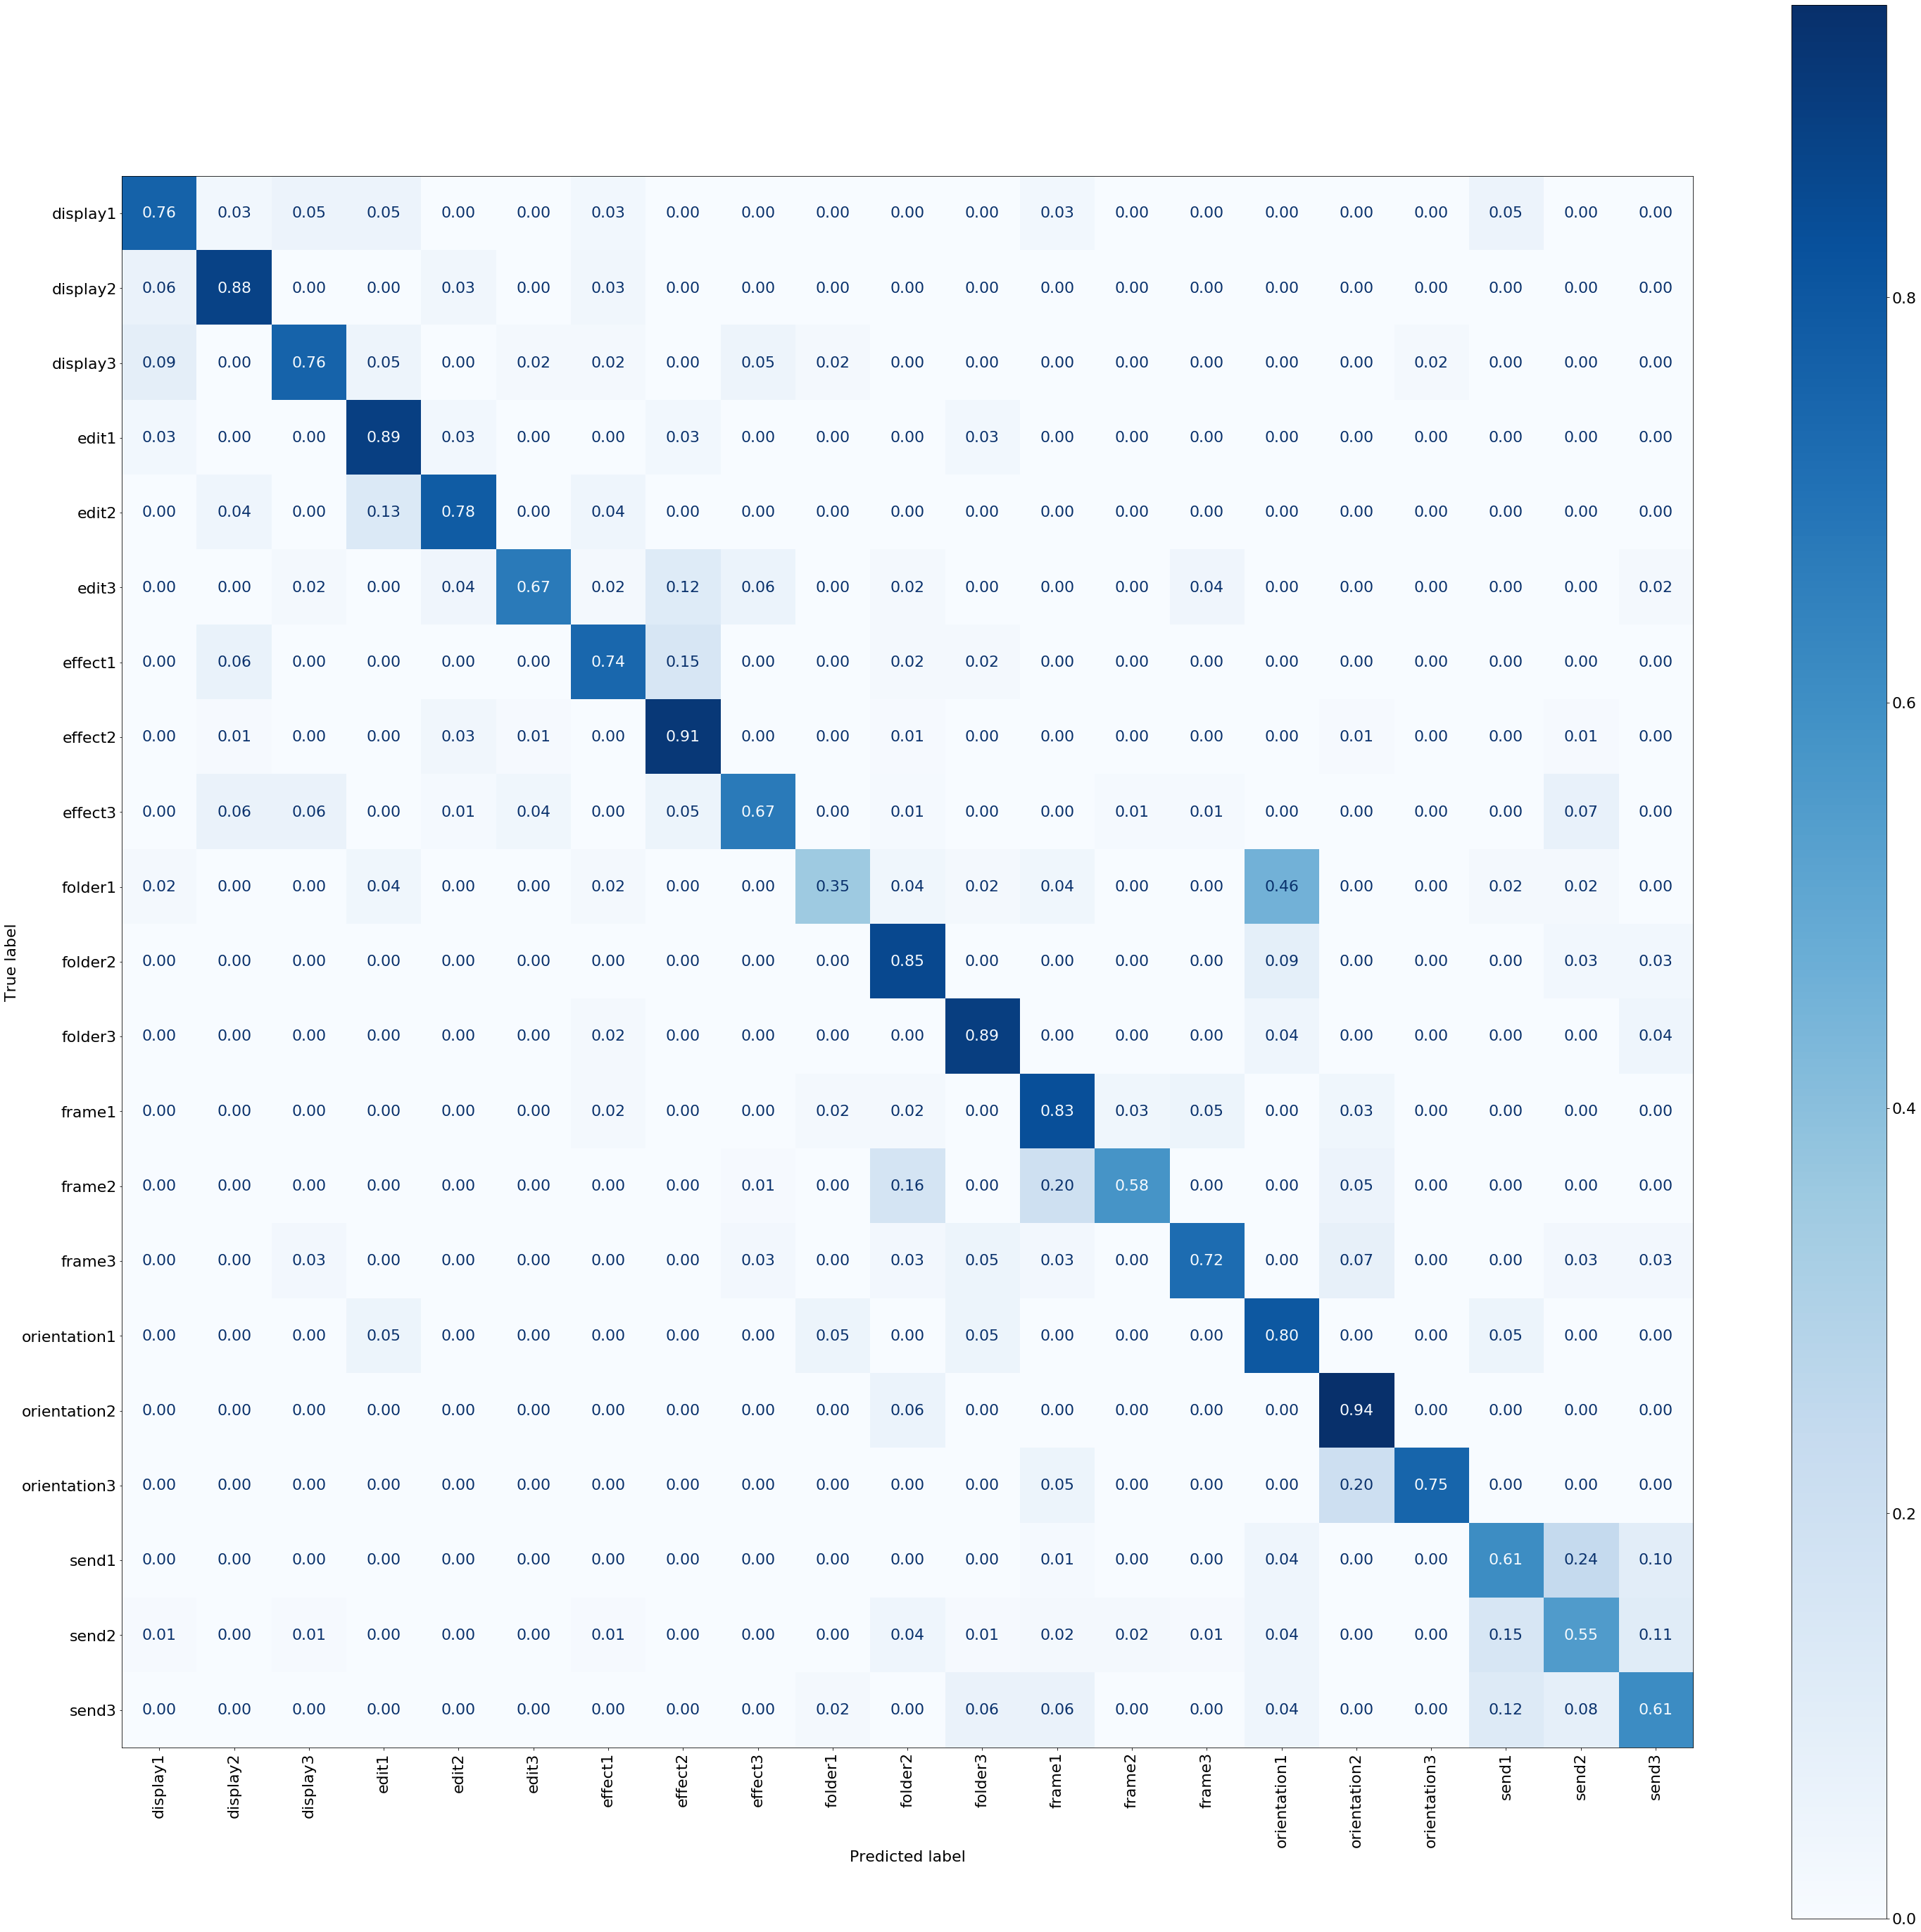

In [18]:
norm_confMatrix = confMatrix / (np.sum(confMatrix, axis=1)[:, np.newaxis])
fig, ax = plt.subplots(figsize=(50,50))
disp = ConfusionMatrixDisplay(confusion_matrix=norm_confMatrix, display_labels=actions)
disp.plot(include_values=True, cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax, values_format=".2f")
plt.savefig(pathModelGeneral + "confusionMatrixNorm"+("_t"+str(t) if t>1 else "")+".png")

## Behaviour with reject

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


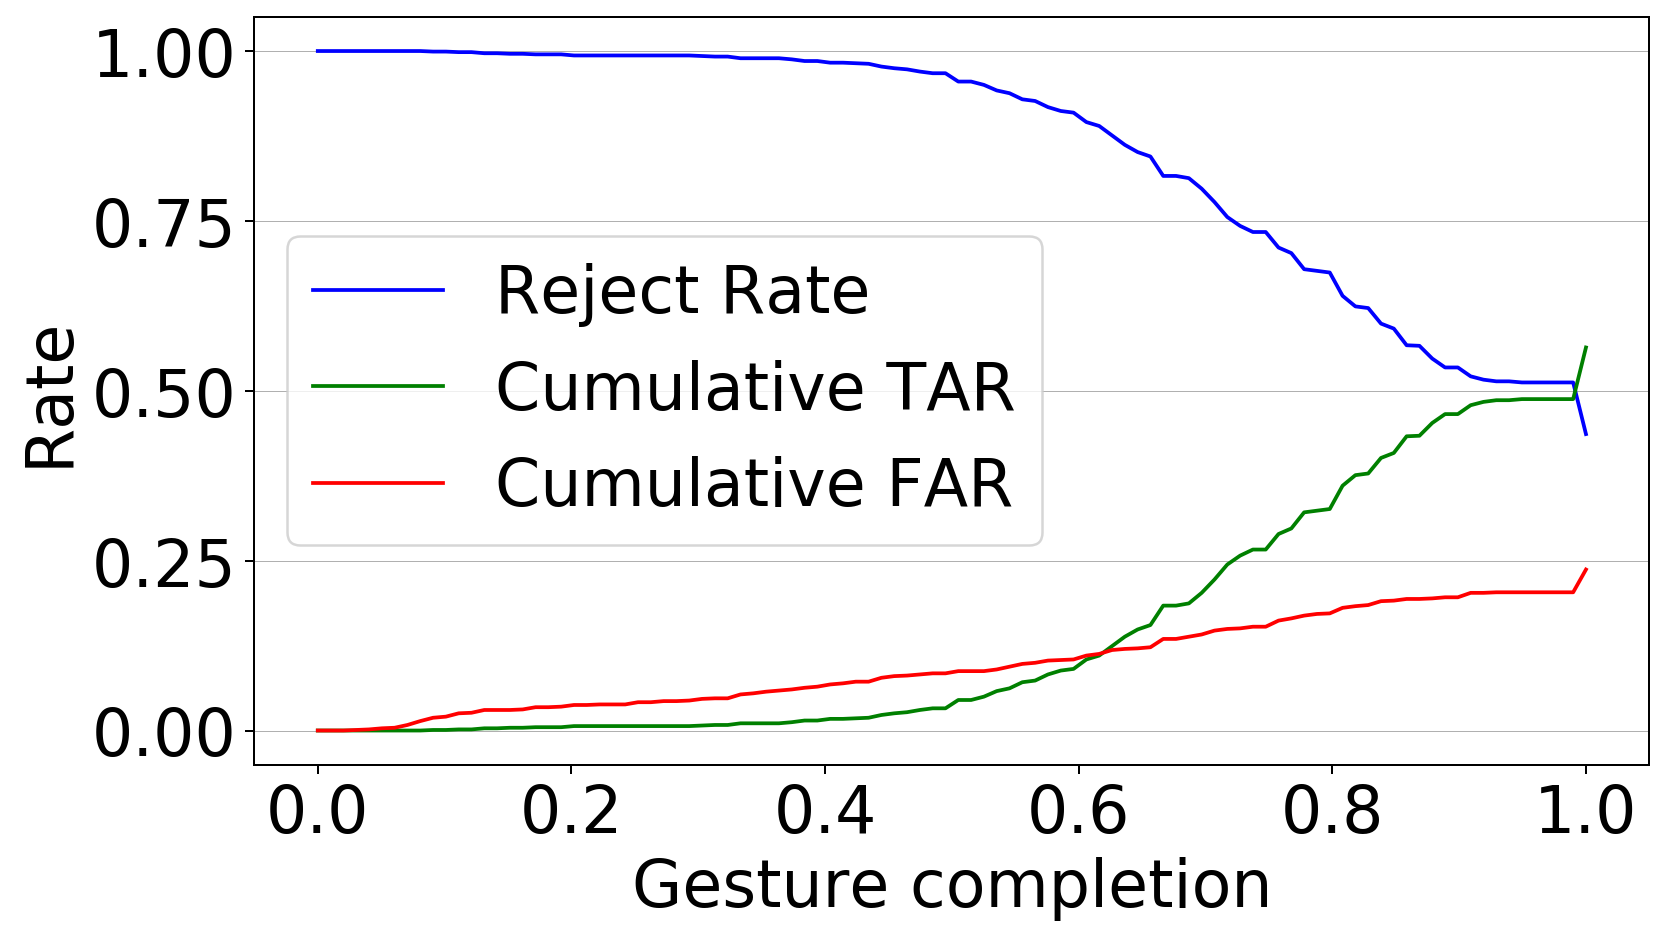

In [19]:
plt.rcParams.update({'font.size': 26})
plt.figure(figsize=(10,5.5),dpi=180)
xAbs = np.linspace(0,1,100)
flat_averageLengthCompletion = [item for sublist in averageLengthCompletion for item in sublist]

lengcomplt = np.array(flat_averageLengthCompletion)
# lengcomplt[]
rejectsAt = np.array(list(map(lambda x : 1-len(lengcomplt[lengcomplt<=x])/N_,xAbs)))
plt.plot(xAbs, rejectsAt,color="blue")


TrueAcceptAt = np.array(TrueAcceptAt)
FalseAcceptAt = np.array(FalseAcceptAt)
totalExemples = len(lengcomplt)

#cumulated TAR and FAR
TARAt = np.array(list(map(lambda x : len(TrueAcceptAt[TrueAcceptAt<=x])/N_,xAbs)))
plt.plot(xAbs, TARAt,color="green")



FARAt = np.array(list(map(lambda x : len(FalseAcceptAt[FalseAcceptAt<=x])/N_,xAbs)))
plt.plot(xAbs, FARAt,color="red")
plt.grid(axis="y",linestyle="-",linewidth=.4)

plt.legend(["Reject Rate","Cumulative TAR","Cumulative FAR"])
plt.xlabel("Gesture completion")
plt.ylabel("Rate")

# plt.plot(X, Yb)
# plt.plot(X, Yb)
plt.savefig(pathModelGeneral+"TAR_FAR_Reject"+("_t"+str(t) if t>1 else "")+".eps", bbox_inches='tight',format='eps')
plt.savefig(pathModelGeneral+"TAR_FAR_Reject"+("_t"+str(t) if t>1 else ""), bbox_inches='tight')